In [1]:
!pip install transformers datasets accelerate scikit-learn matplotlib
!pip install datasets==3.6.0


In [2]:
import GQA_utils
import torch
from torch import nn
import torch.nn.functional as F
from datasets import load_dataset
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
from collections import defaultdict
import math
import torch.nn.init as init
from tqdm.auto import tqdm # Import tqdm for progress bar
from transformers import GPT2LMHeadModel, GPT2Tokenizer, DataCollatorForLanguageModeling
from torch.utils.data import DataLoader


# GQA test for projection matrices movement with Mean Pooling

## Set Model For GQA test

In [3]:
model_name = "gpt2"
model, tokenizer = GQA_utils.get_model(model_name)
model

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [4]:
model.train()
original_matrices = {}
for i in range(len(model.transformer.h)):
  attn_layer = model.transformer.h[i].attn
  W_qkv = attn_layer.c_attn.weight.data
  print(attn_layer.c_attn.weight.data.shape)
  n_embd=768
  W_q_orig = W_qkv[:,0:n_embd]           # [n_embd, n_embd]
  W_k_orig = W_qkv[:,n_embd:2*n_embd]    # [n_embd, n_embd]
  W_v_orig = W_qkv[:,2*n_embd:3*n_embd]
  original_matrices[i] = {
      'W_q': W_q_orig.clone(),
      'W_k': W_k_orig.clone(),
      'W_v': W_v_orig.clone(),
  }
print(original_matrices)



torch.Size([768, 2304])
torch.Size([768, 2304])
torch.Size([768, 2304])
torch.Size([768, 2304])
torch.Size([768, 2304])
torch.Size([768, 2304])
torch.Size([768, 2304])
torch.Size([768, 2304])
torch.Size([768, 2304])
torch.Size([768, 2304])
torch.Size([768, 2304])
torch.Size([768, 2304])
{0: {'W_q': tensor([[-0.4738, -0.2614, -0.0978,  ...,  0.3237, -0.0483, -0.2235],
        [ 0.0874,  0.1473,  0.2387,  ..., -0.0770, -0.1492,  0.1507],
        [ 0.0039,  0.0695,  0.3668,  ..., -0.1235, -0.1660, -0.0480],
        ...,
        [-0.2592, -0.0164,  0.1991,  ..., -0.0335,  0.1455,  0.0333],
        [ 0.1517,  0.2170,  0.1043,  ...,  0.0827, -0.0533, -0.0071],
        [-0.4100, -0.1924, -0.2400,  ...,  0.2170,  0.1470, -0.0557]]), 'W_k': tensor([[ 0.3660,  0.0771,  0.2226,  ..., -0.0392, -0.2204, -0.1203],
        [-0.4380, -0.1446, -0.4717,  ..., -0.1312, -0.1007, -0.2032],
        [ 0.1237,  0.0174,  0.1181,  ..., -0.0182,  0.2173, -0.0052],
        ...,
        [-0.2009, -0.2453, -0.1728,

In [5]:
embed_dim = model.config.n_embd
for i in range(len(model.transformer.h)):
  gqa_layer = GQA_utils.GQAAttention(model.transformer.h[i].attn, K=4, layer_idx=i)
  model.transformer.h[i].attn = gqa_layer


In [6]:
model

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GQAAttention(
          (out_proj): Conv1D(nf=768, nx=768)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

## Uptraining

In [7]:
matrix_evolution = {}

GQA_log = GQA_utils.train_model(model, tokenizer, matrix_evolution)

Starting training on cuda for 5 epochs...

--- Epoch 1/5 ---


Epoch 1:   0%|          | 0/6447 [00:00<?, ?it/s]

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Epoch 1 finished. Average Loss: 4.2958
Validation Loss: 3.6139

--- Epoch 2/5 ---


Epoch 2:   0%|          | 0/6447 [00:00<?, ?it/s]

Epoch 2 finished. Average Loss: 2.1754
Validation Loss: 1.4887

--- Epoch 3/5 ---


Epoch 3:   0%|          | 0/6447 [00:00<?, ?it/s]

Epoch 3 finished. Average Loss: 1.1543
Validation Loss: 1.0337

--- Epoch 4/5 ---


Epoch 4:   0%|          | 0/6447 [00:00<?, ?it/s]

Epoch 4 finished. Average Loss: 0.7659
Validation Loss: 0.8083

--- Epoch 5/5 ---


Epoch 5:   0%|          | 0/6447 [00:00<?, ?it/s]

Epoch 5 finished. Average Loss: 0.5378
Validation Loss: 0.6674

Training complete!


In [8]:
import pickle
with open('data.pkl', 'wb') as f:
    pickle.dump(matrix_evolution, f)

In [9]:
for i in range(len(model.transformer.h)):
  matrix_evolution[i]['W_v'] = torch.tensor(matrix_evolution[i]['W_v']).permute(1,0,2,3)
  matrix_evolution[i]['W_q'] = torch.tensor(matrix_evolution[i]['W_q']).permute(1,0,2,3)
  matrix_evolution[i]['W_k'] = torch.tensor(matrix_evolution[i]['W_k']).permute(1,0,2,3)


/tmp/ipython-input-9-1290015737.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  matrix_evolution[i]['W_v'] = torch.tensor(matrix_evolution[i]['W_v']).permute(1,0,2,3)


## Plotting

(12, 49152)
<class 'numpy.ndarray'>
(12, 49152)
<class 'numpy.ndarray'>
(12, 49152)
<class 'numpy.ndarray'>
(12, 49152)
<class 'numpy.ndarray'>
(12, 49152)
<class 'numpy.ndarray'>
(12, 49152)
<class 'numpy.ndarray'>
(12, 49152)
<class 'numpy.ndarray'>
(12, 49152)
<class 'numpy.ndarray'>
(12, 49152)
<class 'numpy.ndarray'>
(12, 49152)
<class 'numpy.ndarray'>
(12, 49152)
<class 'numpy.ndarray'>
(12, 49152)
<class 'numpy.ndarray'>


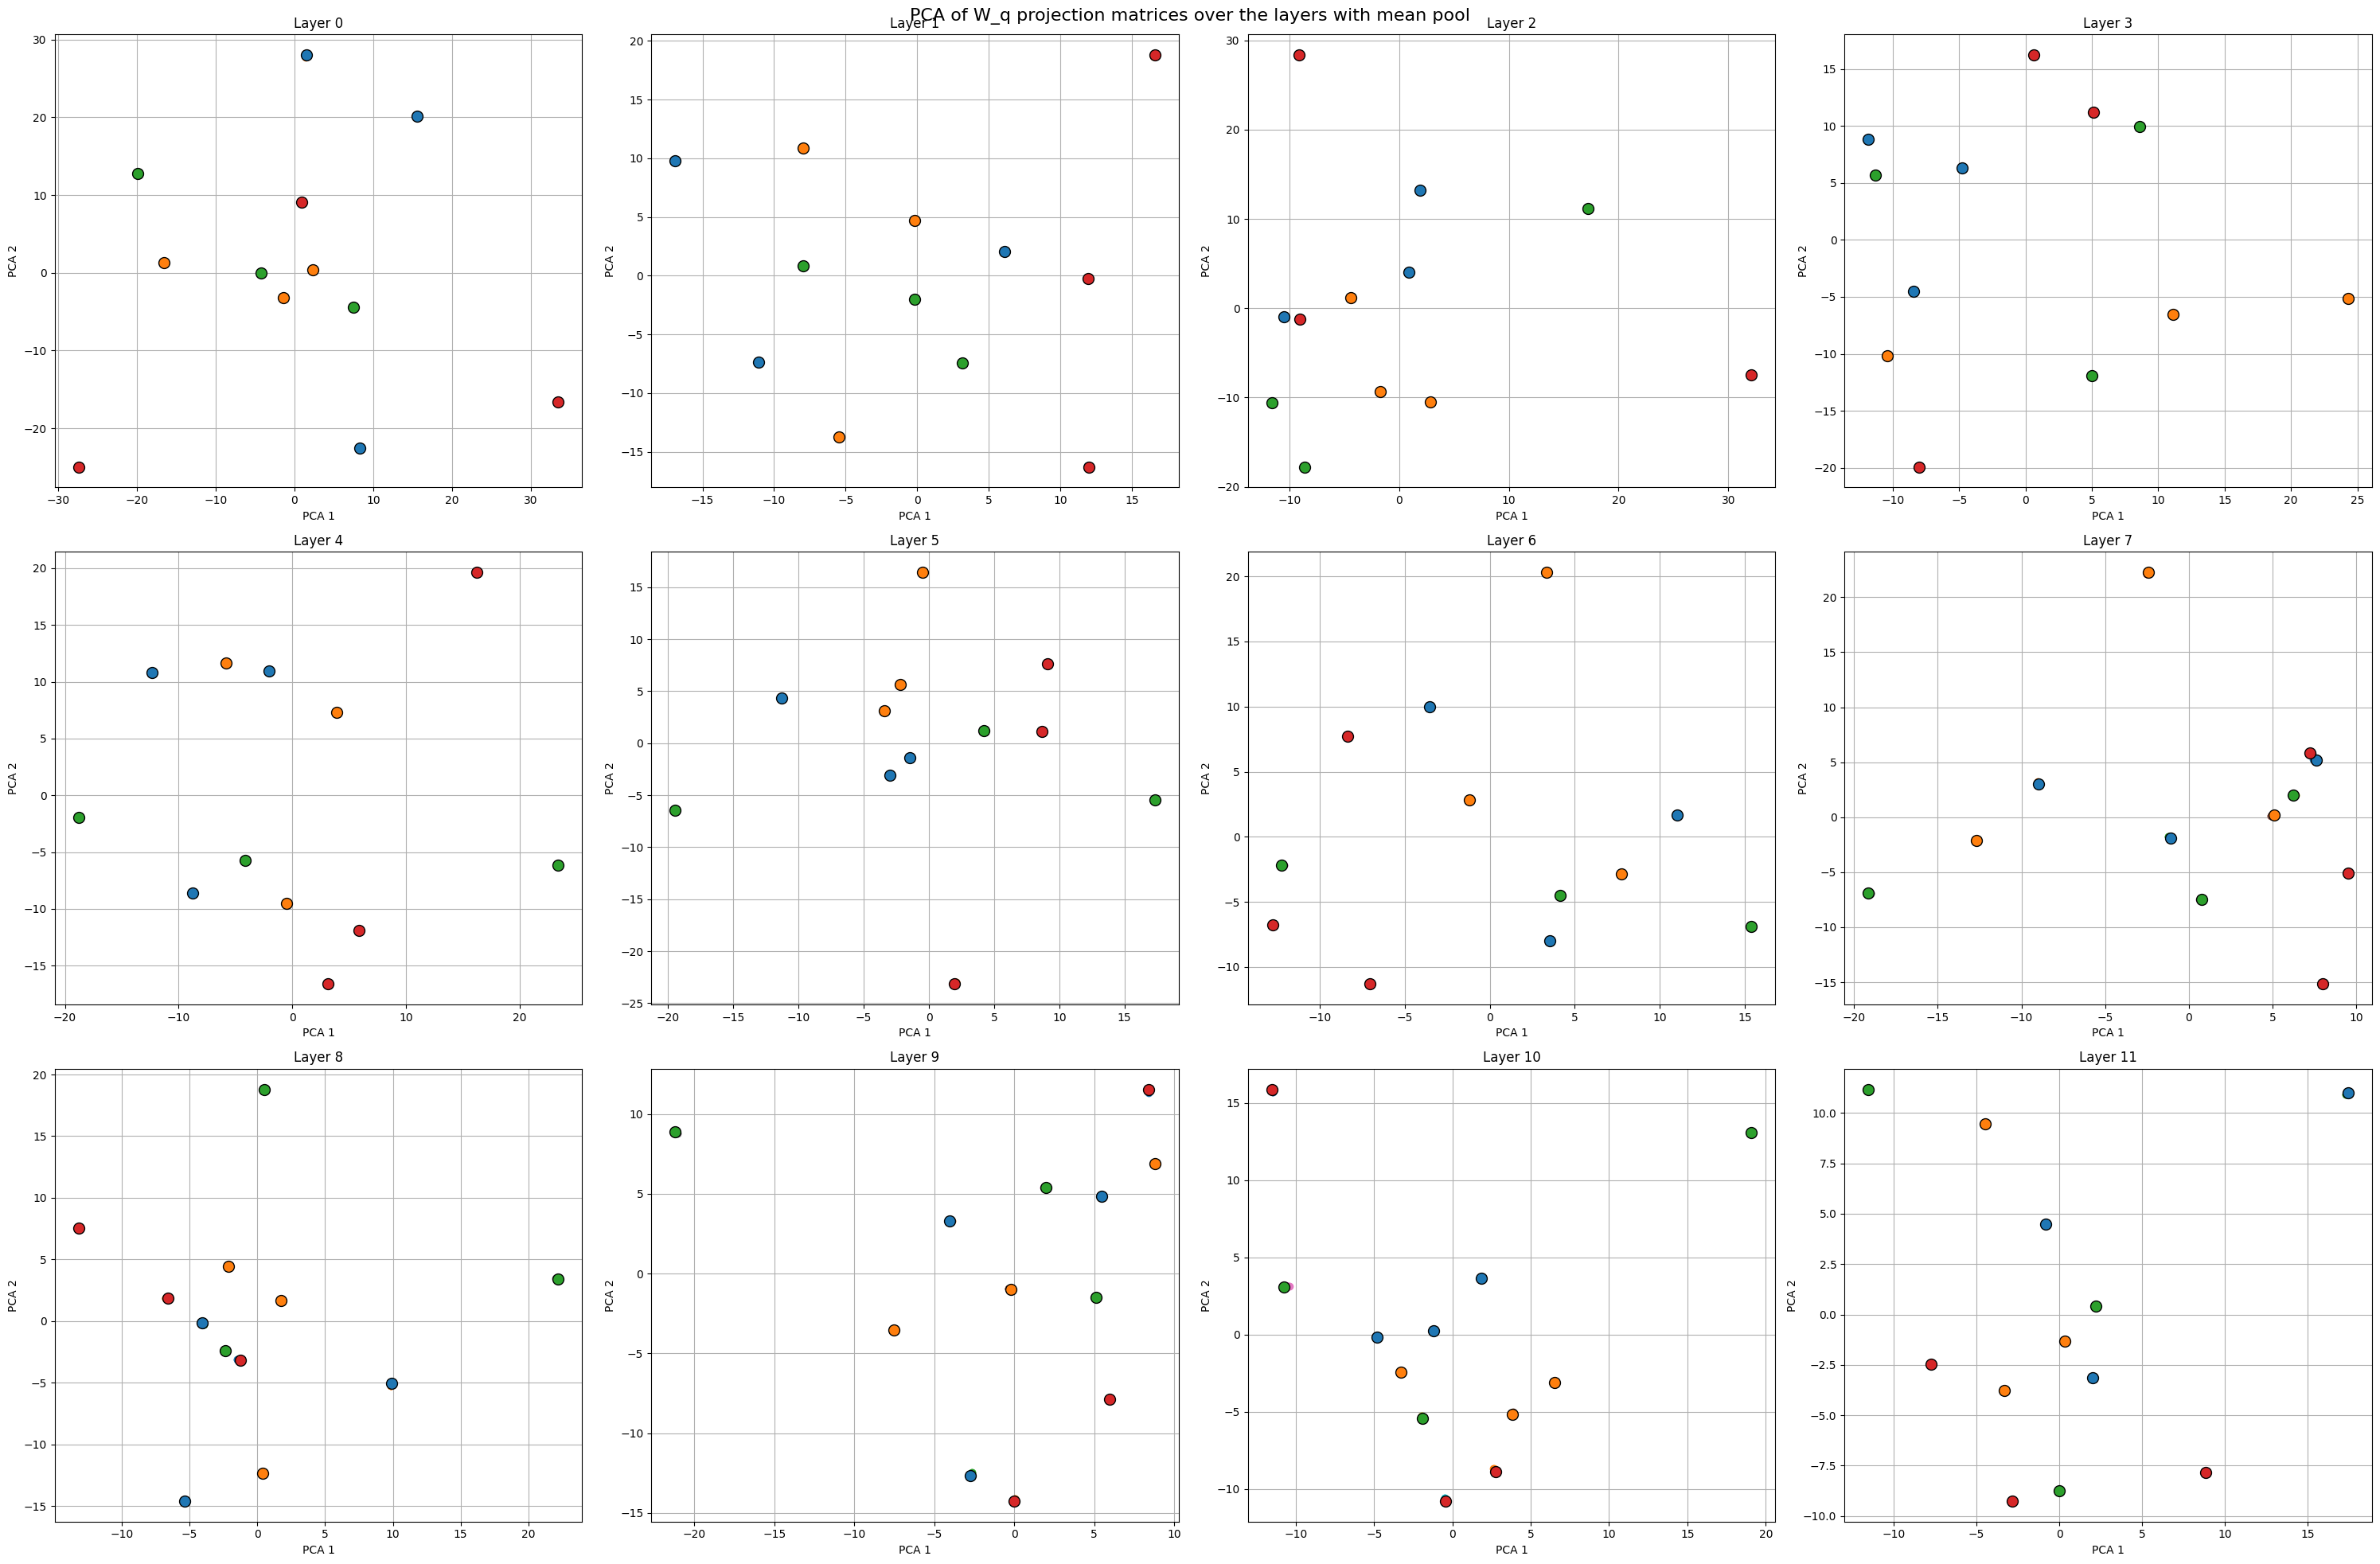

(12, 49152)
<class 'numpy.ndarray'>
(12, 49152)
<class 'numpy.ndarray'>
(12, 49152)
<class 'numpy.ndarray'>
(12, 49152)
<class 'numpy.ndarray'>
(12, 49152)
<class 'numpy.ndarray'>
(12, 49152)
<class 'numpy.ndarray'>
(12, 49152)
<class 'numpy.ndarray'>
(12, 49152)
<class 'numpy.ndarray'>
(12, 49152)
<class 'numpy.ndarray'>
(12, 49152)
<class 'numpy.ndarray'>
(12, 49152)
<class 'numpy.ndarray'>
(12, 49152)
<class 'numpy.ndarray'>


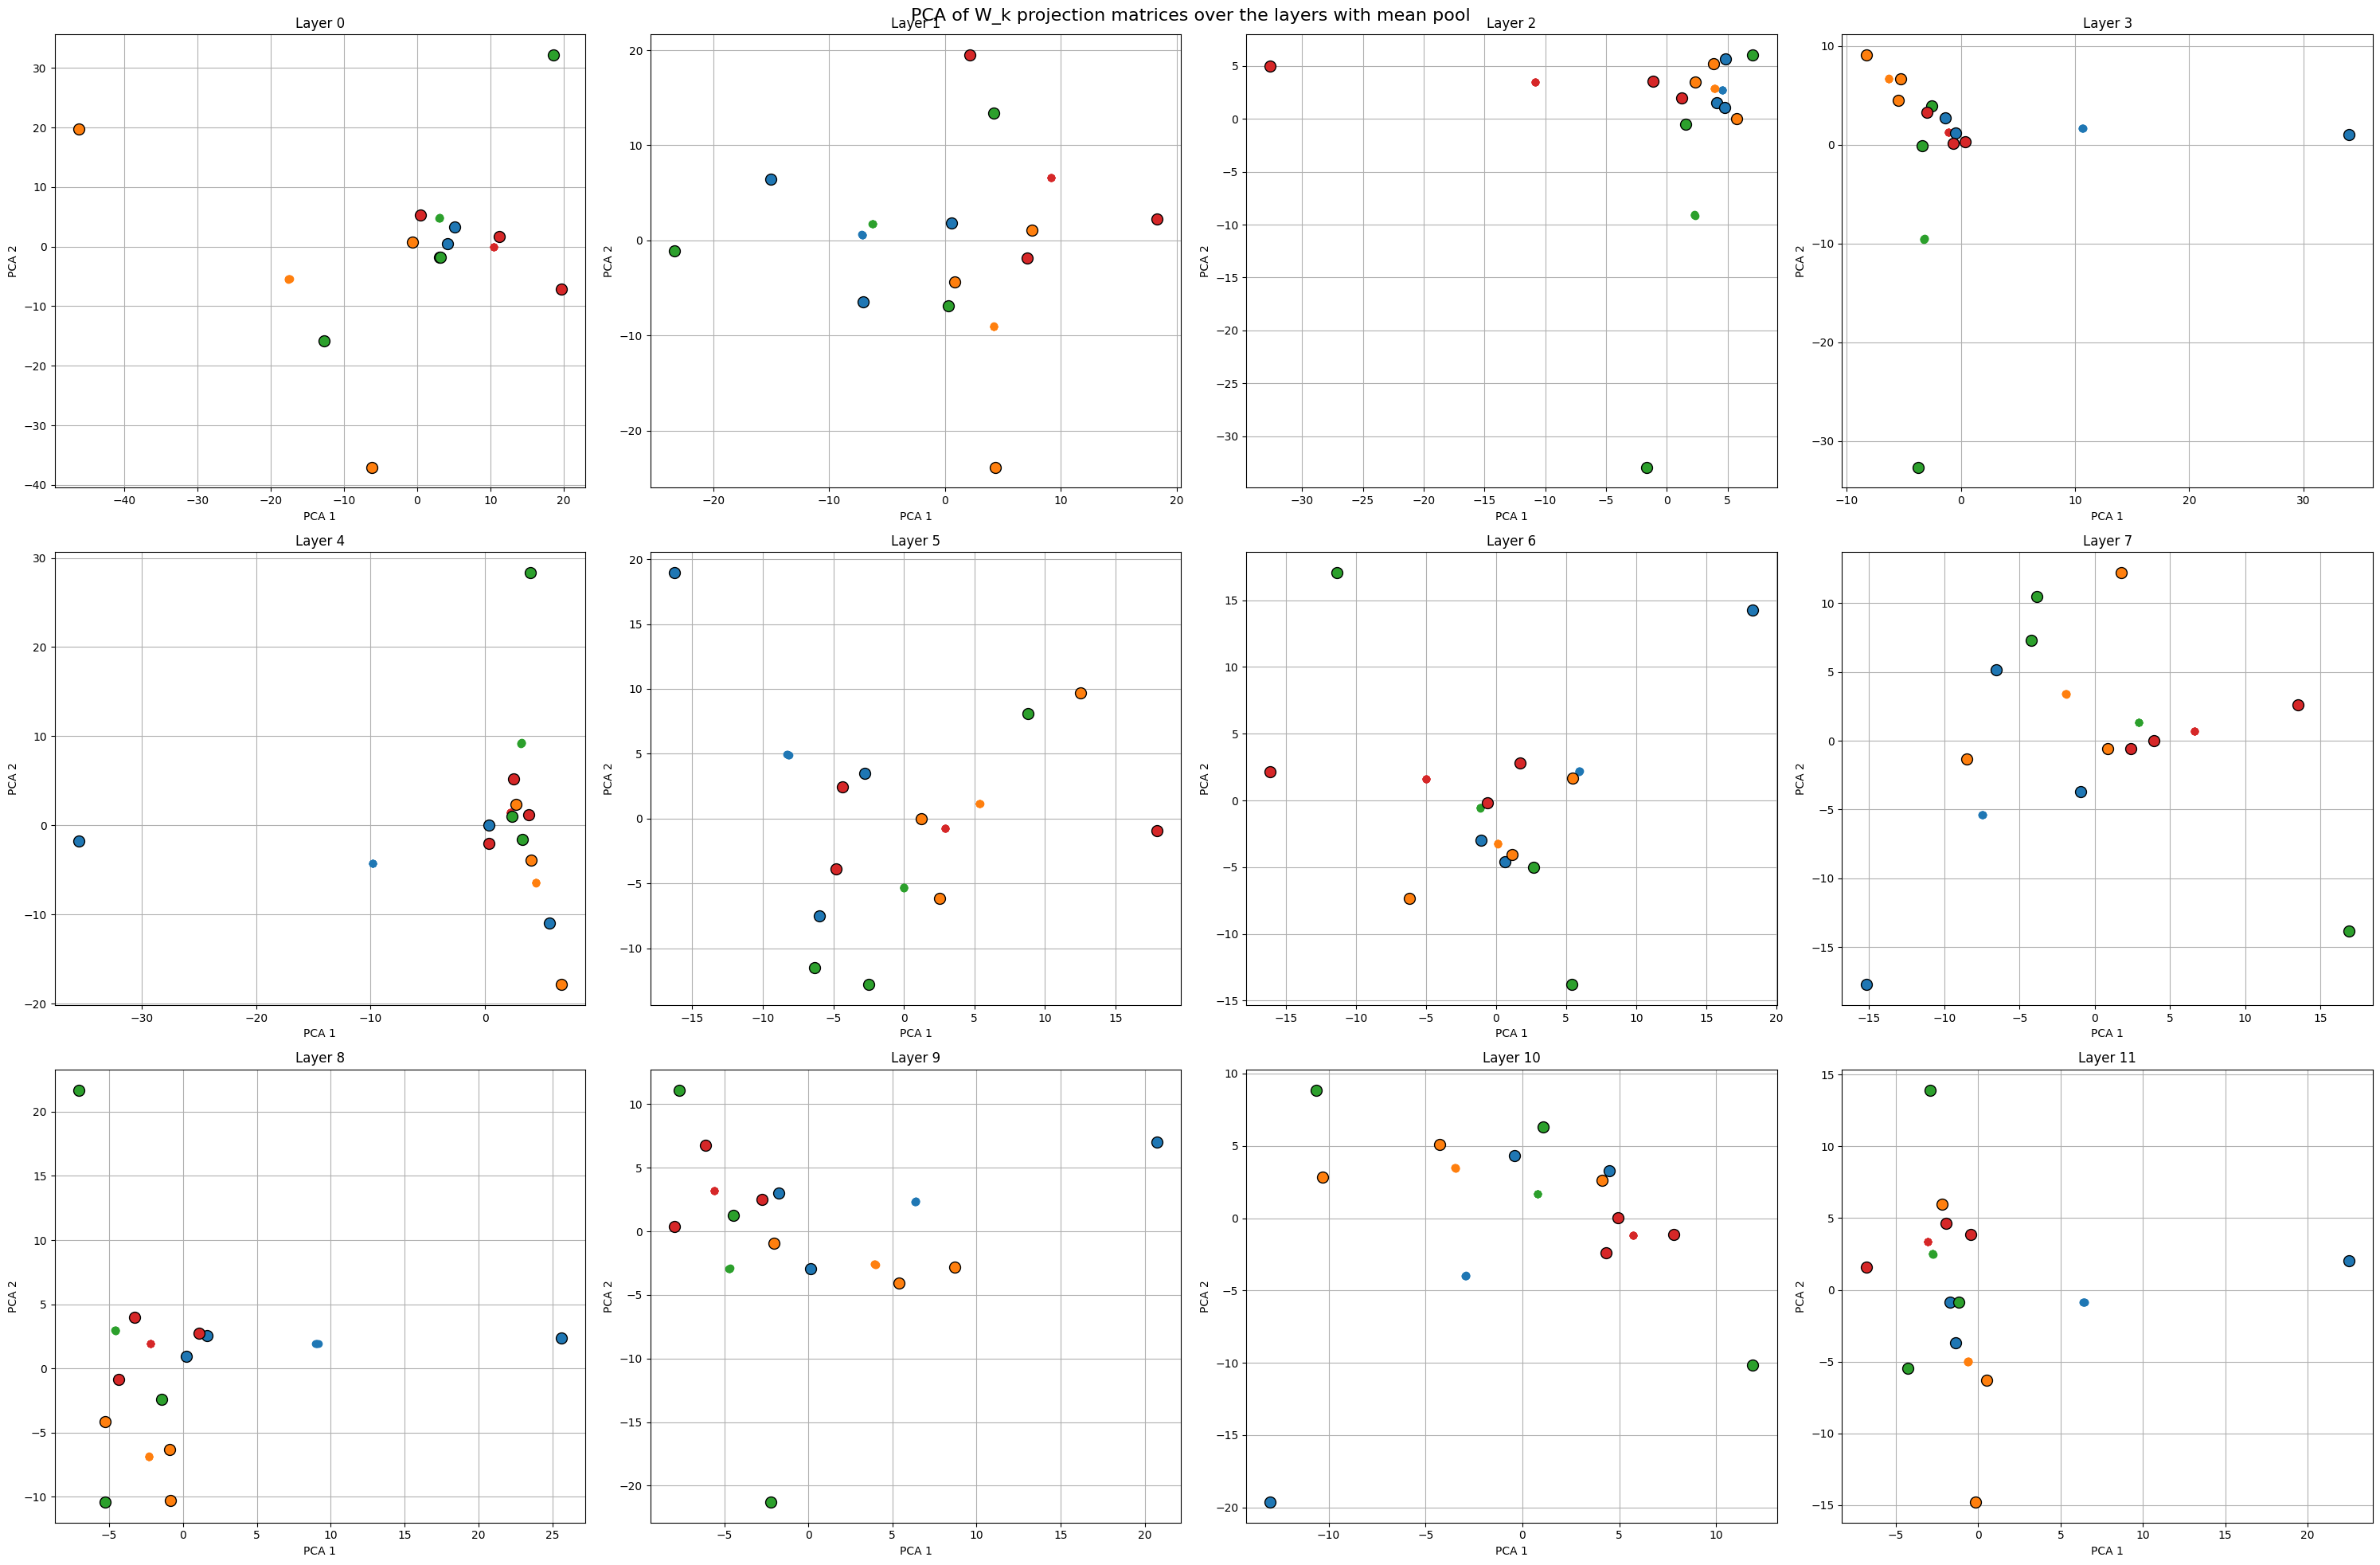

(12, 49152)
<class 'numpy.ndarray'>
(12, 49152)
<class 'numpy.ndarray'>
(12, 49152)
<class 'numpy.ndarray'>
(12, 49152)
<class 'numpy.ndarray'>
(12, 49152)
<class 'numpy.ndarray'>
(12, 49152)
<class 'numpy.ndarray'>
(12, 49152)
<class 'numpy.ndarray'>
(12, 49152)
<class 'numpy.ndarray'>
(12, 49152)
<class 'numpy.ndarray'>
(12, 49152)
<class 'numpy.ndarray'>
(12, 49152)
<class 'numpy.ndarray'>
(12, 49152)
<class 'numpy.ndarray'>


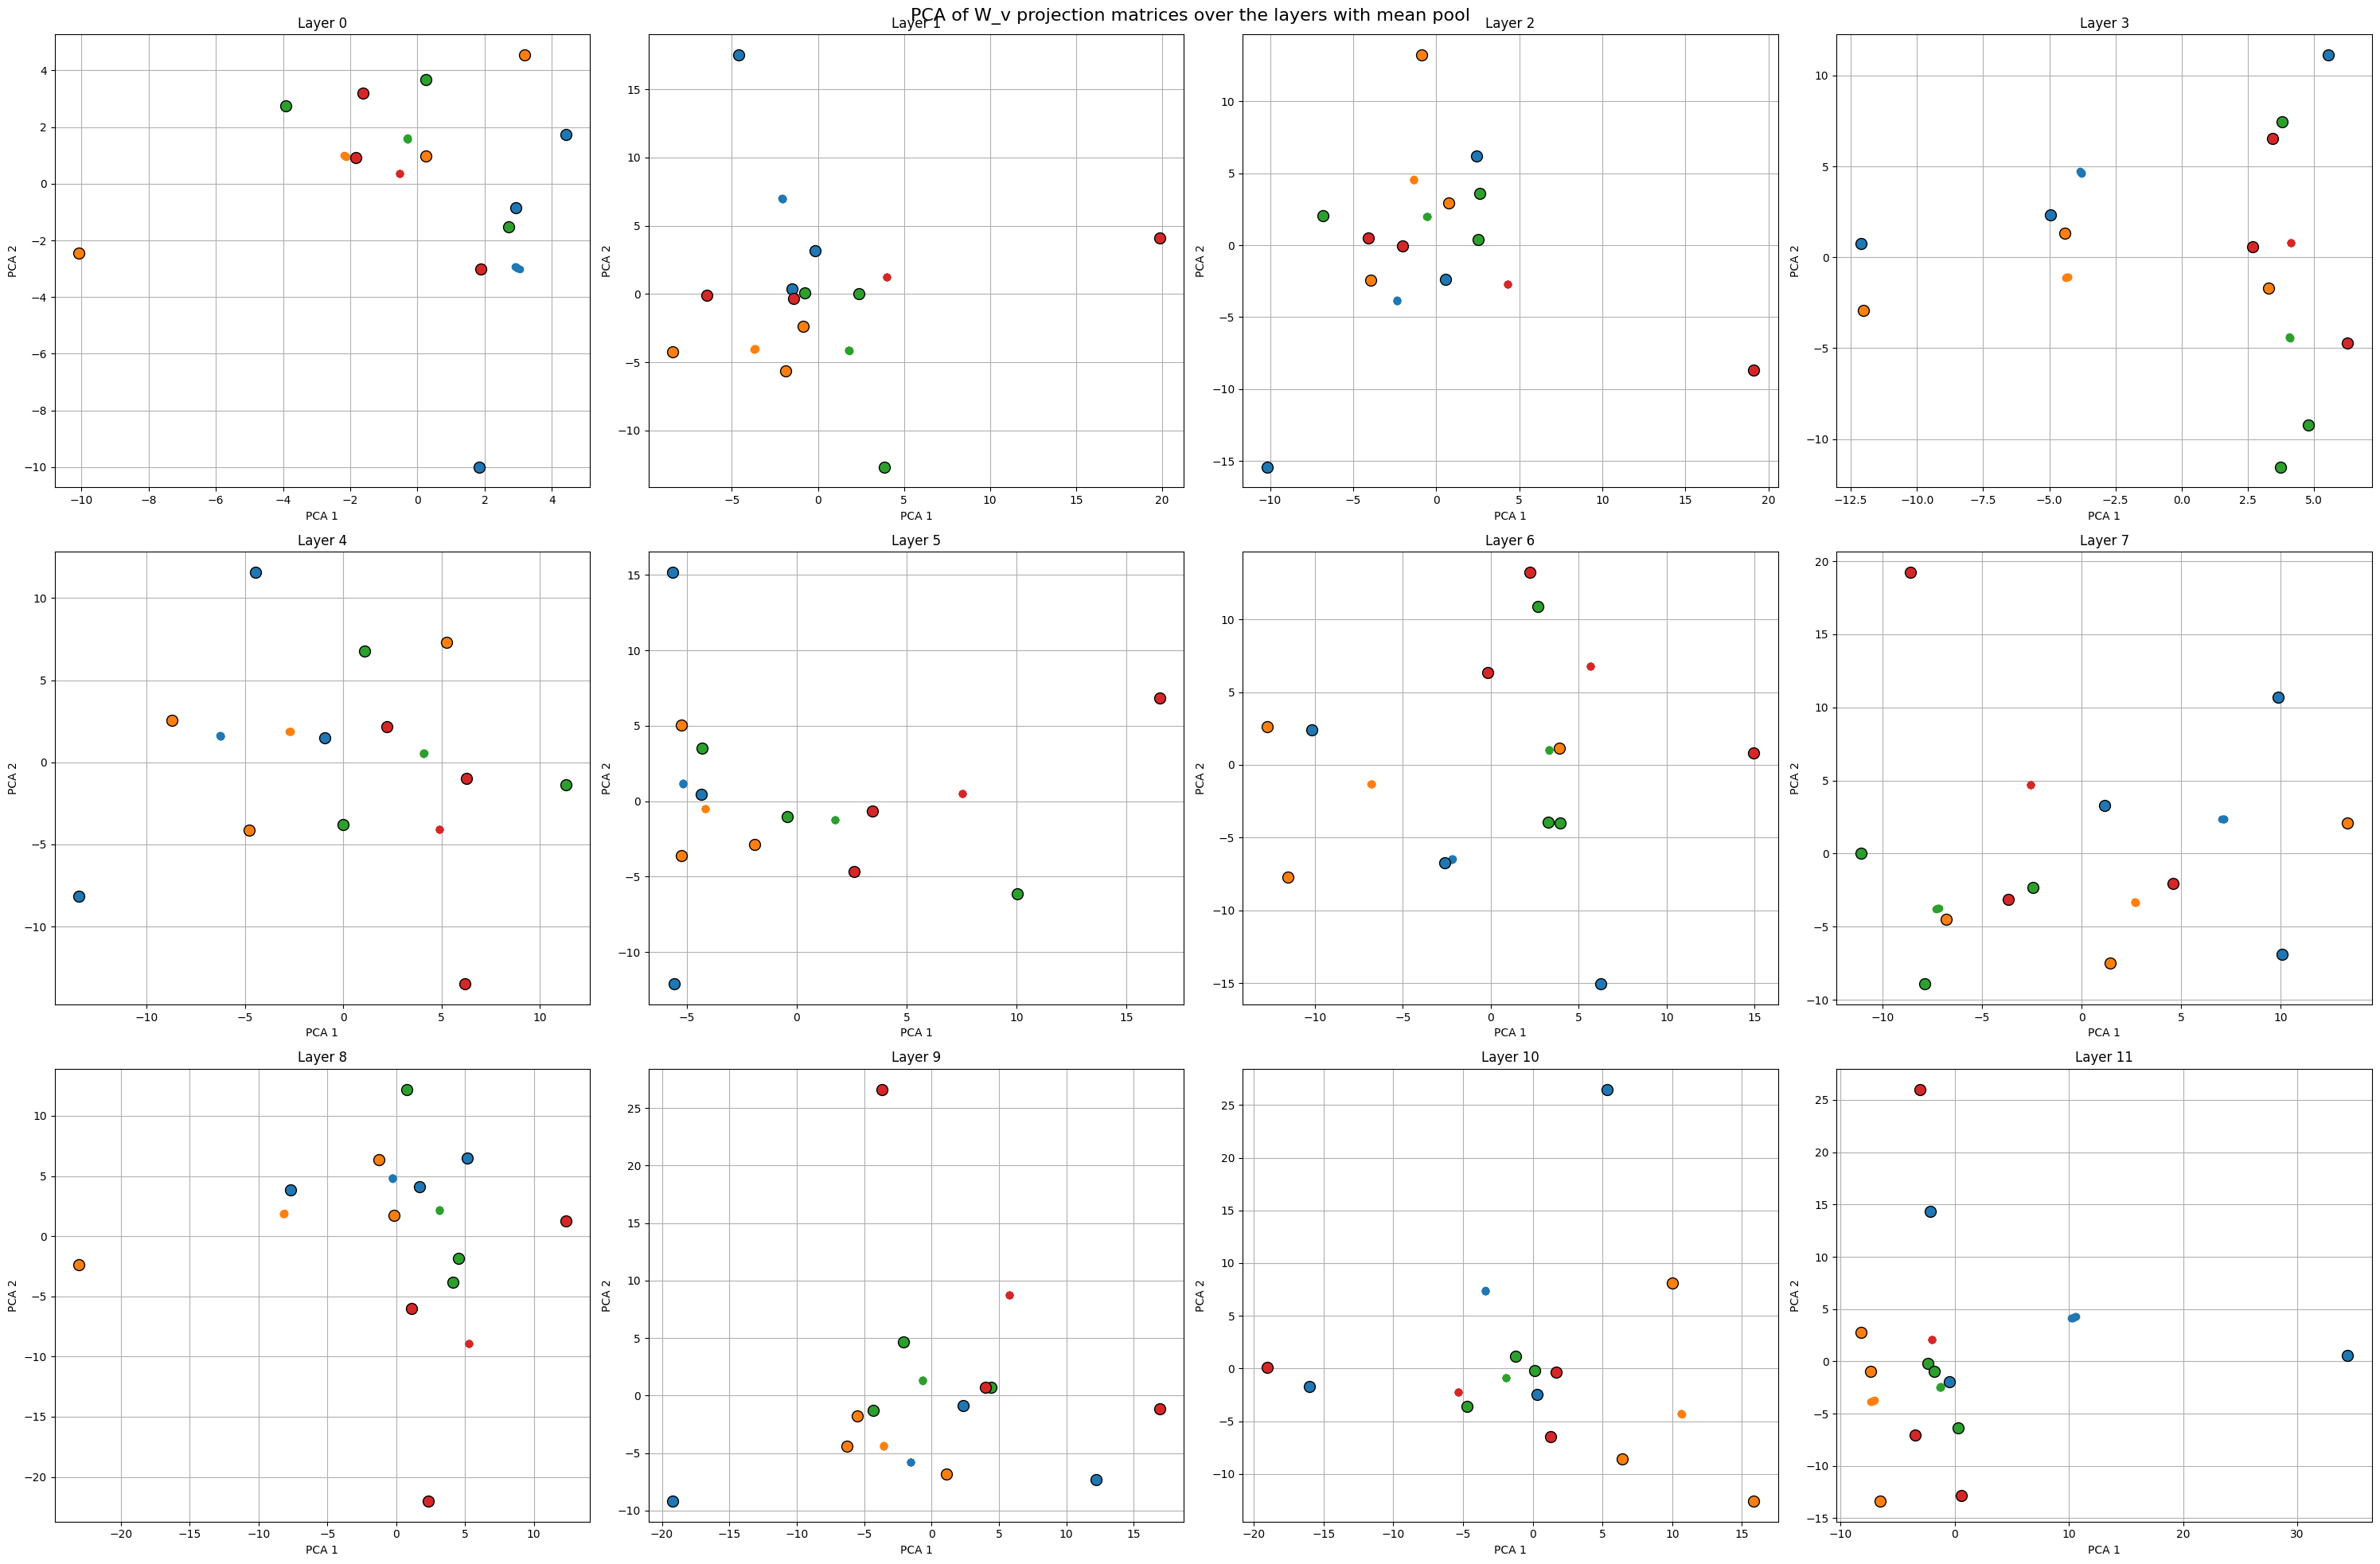

In [10]:

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.cm as cm

pca = PCA(n_components=2)

for name in ["W_q", "W_k", "W_v"]:
  fig, axes = plt.subplots(3, 4, figsize=(30, 20))
  fig.suptitle(f'PCA of {name} projection matrices over the layers with mean pool', fontsize=16)
  for i in range(len(model.transformer.h)):
    row = i // 4
    col = i % 4
    ax = axes[row, col]
    ax.set_title(f'Layer {i}')

    num_heads = 4

    if name == 'W_q':
      num_heads = 12

    trajectories = []
    for trajectory in list(matrix_evolution[i][name]):
      temp = list(trajectory)
      trajectories.append([t.flatten() for t in temp])

    flattened_traj = [m for traj in trajectories for m in traj]

    T = len(list(matrix_evolution[i][name][0]))
    origin = original_matrices[i][name].view(12, 49152).cpu().detach().numpy()
    print(origin.shape)  # Should be (12, 49152)
    print(type(origin))  # Should be <class 'numpy.ndarray'>

    reduced = pca.fit_transform(origin)
    reduced_orig = reduced[:12]

    # Plot each trajectory
    for j in range(num_heads):

        traj = pca.transform(trajectories[j]).reshape(T,2)
        # Draw the trajectory line
        ax.plot(traj[:, 0], traj[:, 1], marker='o', linewidth=2, label=f'Head {j}')

    # Plot original positions with labels
    labels = ['Group 1', 'Group 2', 'Group 3', 'Group 4']

    for group_idx in range(len(labels)):
        group_points = reduced_orig[group_idx * 3 : (group_idx + 1) * 3]
        x, y = group_points[:, 0], group_points[:, 1]
        ax.scatter(x, y, edgecolor='black', s=100, zorder=5, label=labels[group_idx])

    # ax.legend()
    ax.grid(True)
    ax.set_xlabel("PCA 1")
    ax.set_ylabel("PCA 2")
  plt.tight_layout()
  plt.show()


# GQA test for projection matrices movement with Random Initialization

## Set Model For GQA test

In [11]:
model_name = "gpt2"
model, tokenizer = GQA_utils.get_model(model_name)
model

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [12]:
model.train()
original_matrices = {}
for i in range(len(model.transformer.h)):
  attn_layer = model.transformer.h[i].attn
  W_qkv = attn_layer.c_attn.weight.data
  print(attn_layer.c_attn.weight.data.shape)
  n_embd=768
  W_q_orig = W_qkv[:,0:n_embd]           # [n_embd, n_embd]
  W_k_orig = W_qkv[:,n_embd:2*n_embd]    # [n_embd, n_embd]
  W_v_orig = W_qkv[:,2*n_embd:3*n_embd]
  original_matrices[i] = {
      'W_q': W_q_orig.clone(),
      'W_k': W_k_orig.clone(),
      'W_v': W_v_orig.clone(),
  }
print(original_matrices)



torch.Size([768, 2304])
torch.Size([768, 2304])
torch.Size([768, 2304])
torch.Size([768, 2304])
torch.Size([768, 2304])
torch.Size([768, 2304])
torch.Size([768, 2304])
torch.Size([768, 2304])
torch.Size([768, 2304])
torch.Size([768, 2304])
torch.Size([768, 2304])
torch.Size([768, 2304])
{0: {'W_q': tensor([[-0.4738, -0.2614, -0.0978,  ...,  0.3237, -0.0483, -0.2235],
        [ 0.0874,  0.1473,  0.2387,  ..., -0.0770, -0.1492,  0.1507],
        [ 0.0039,  0.0695,  0.3668,  ..., -0.1235, -0.1660, -0.0480],
        ...,
        [-0.2592, -0.0164,  0.1991,  ..., -0.0335,  0.1455,  0.0333],
        [ 0.1517,  0.2170,  0.1043,  ...,  0.0827, -0.0533, -0.0071],
        [-0.4100, -0.1924, -0.2400,  ...,  0.2170,  0.1470, -0.0557]]), 'W_k': tensor([[ 0.3660,  0.0771,  0.2226,  ..., -0.0392, -0.2204, -0.1203],
        [-0.4380, -0.1446, -0.4717,  ..., -0.1312, -0.1007, -0.2032],
        [ 0.1237,  0.0174,  0.1181,  ..., -0.0182,  0.2173, -0.0052],
        ...,
        [-0.2009, -0.2453, -0.1728,

In [13]:
embed_dim = model.config.n_embd
for i in range(len(model.transformer.h)):
  gqa_layer = GQA_utils.GQAAttention(model.transformer.h[i].attn, K=4, mean_pool=False)
  model.transformer.h[i].attn = gqa_layer


## Uptraining

In [14]:
matrix_evolution = {}

GQA_rand_log = GQA_utils.train_model(model, tokenizer, matrix_evolution)

Starting training on cuda for 5 epochs...

--- Epoch 1/5 ---


Epoch 1:   0%|          | 0/6447 [00:00<?, ?it/s]

Epoch 1 finished. Average Loss: 4.3092
Validation Loss: 3.5497

--- Epoch 2/5 ---


Epoch 2:   0%|          | 0/6447 [00:00<?, ?it/s]

Epoch 2 finished. Average Loss: 2.0131
Validation Loss: 1.2881

--- Epoch 3/5 ---


Epoch 3:   0%|          | 0/6447 [00:00<?, ?it/s]

Epoch 3 finished. Average Loss: 0.9649
Validation Loss: 0.7805

--- Epoch 4/5 ---


Epoch 4:   0%|          | 0/6447 [00:00<?, ?it/s]

Epoch 4 finished. Average Loss: 0.5893
Validation Loss: 0.6255

--- Epoch 5/5 ---


Epoch 5:   0%|          | 0/6447 [00:00<?, ?it/s]

Epoch 5 finished. Average Loss: 0.3634
Validation Loss: 0.4447

Training complete!


In [15]:
import pickle
with open('data_Random.pkl', 'wb') as f:
    pickle.dump(matrix_evolution, f)

In [16]:
for i in range(len(model.transformer.h)):
  matrix_evolution[i]['W_v'] = torch.tensor(matrix_evolution[i]['W_v']).permute(1,0,2,3)
  matrix_evolution[i]['W_q'] = torch.tensor(matrix_evolution[i]['W_q']).permute(1,0,2,3)
  matrix_evolution[i]['W_k'] = torch.tensor(matrix_evolution[i]['W_k']).permute(1,0,2,3)


## Plotting

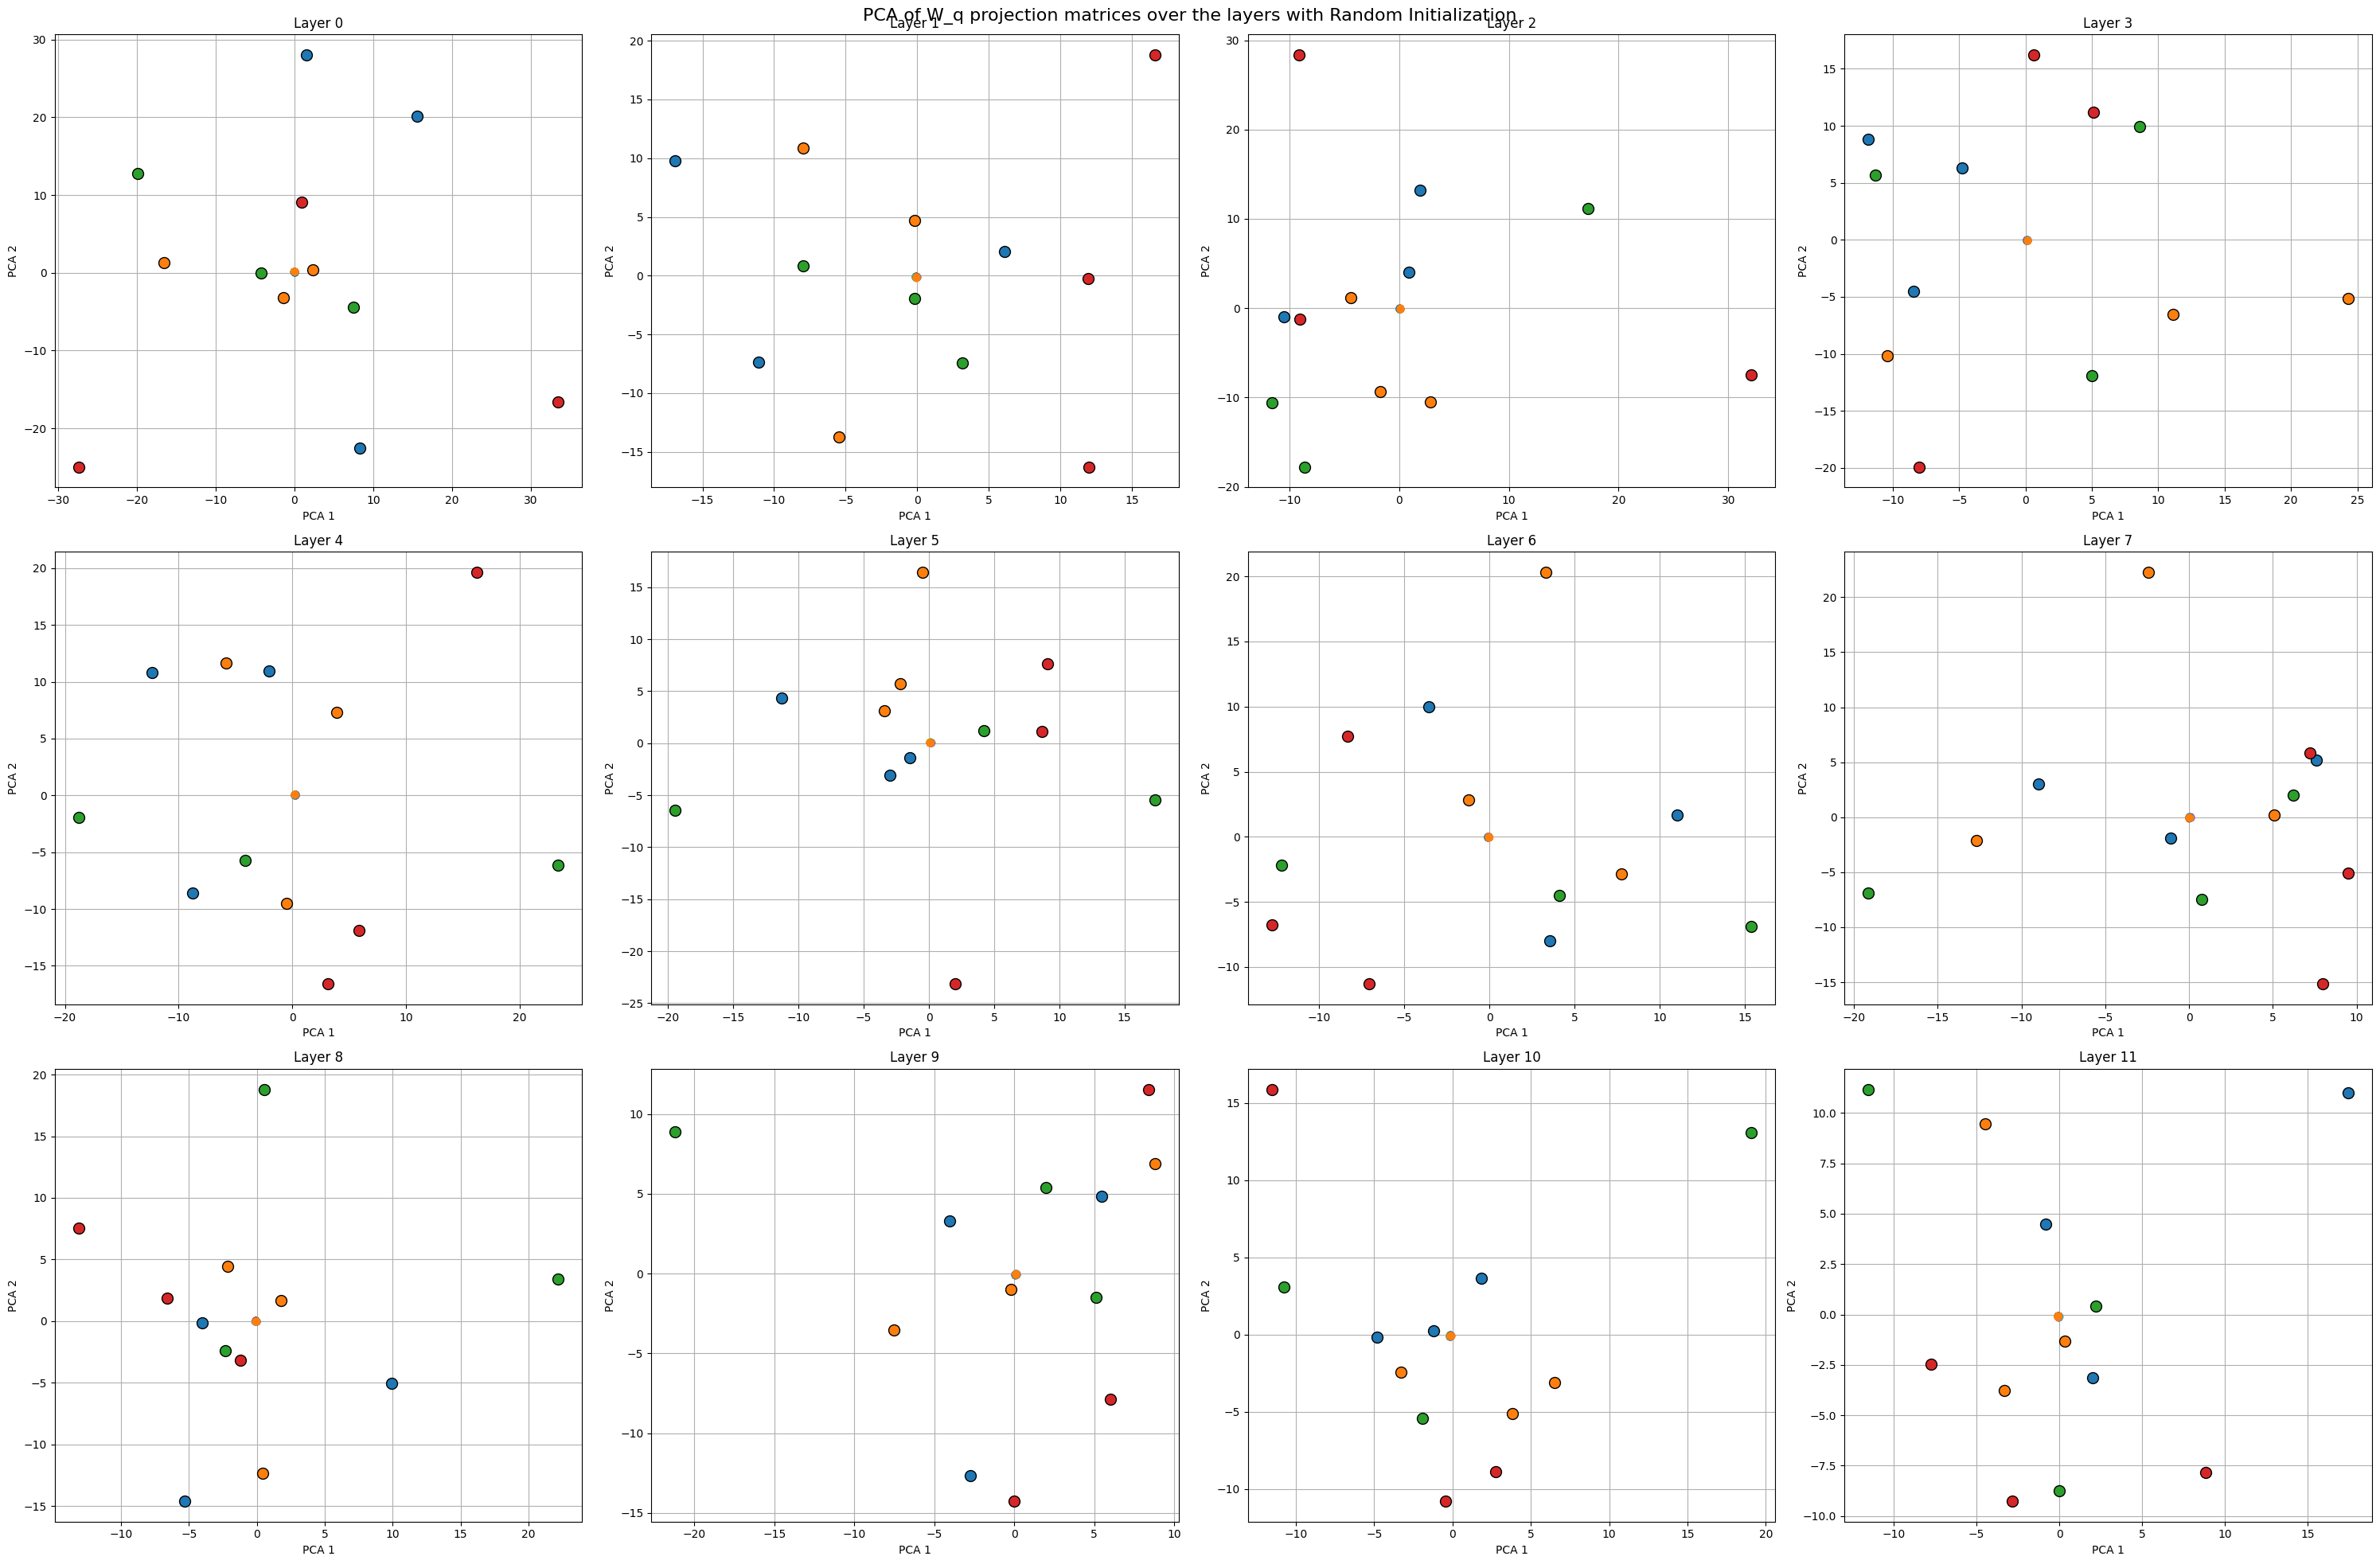

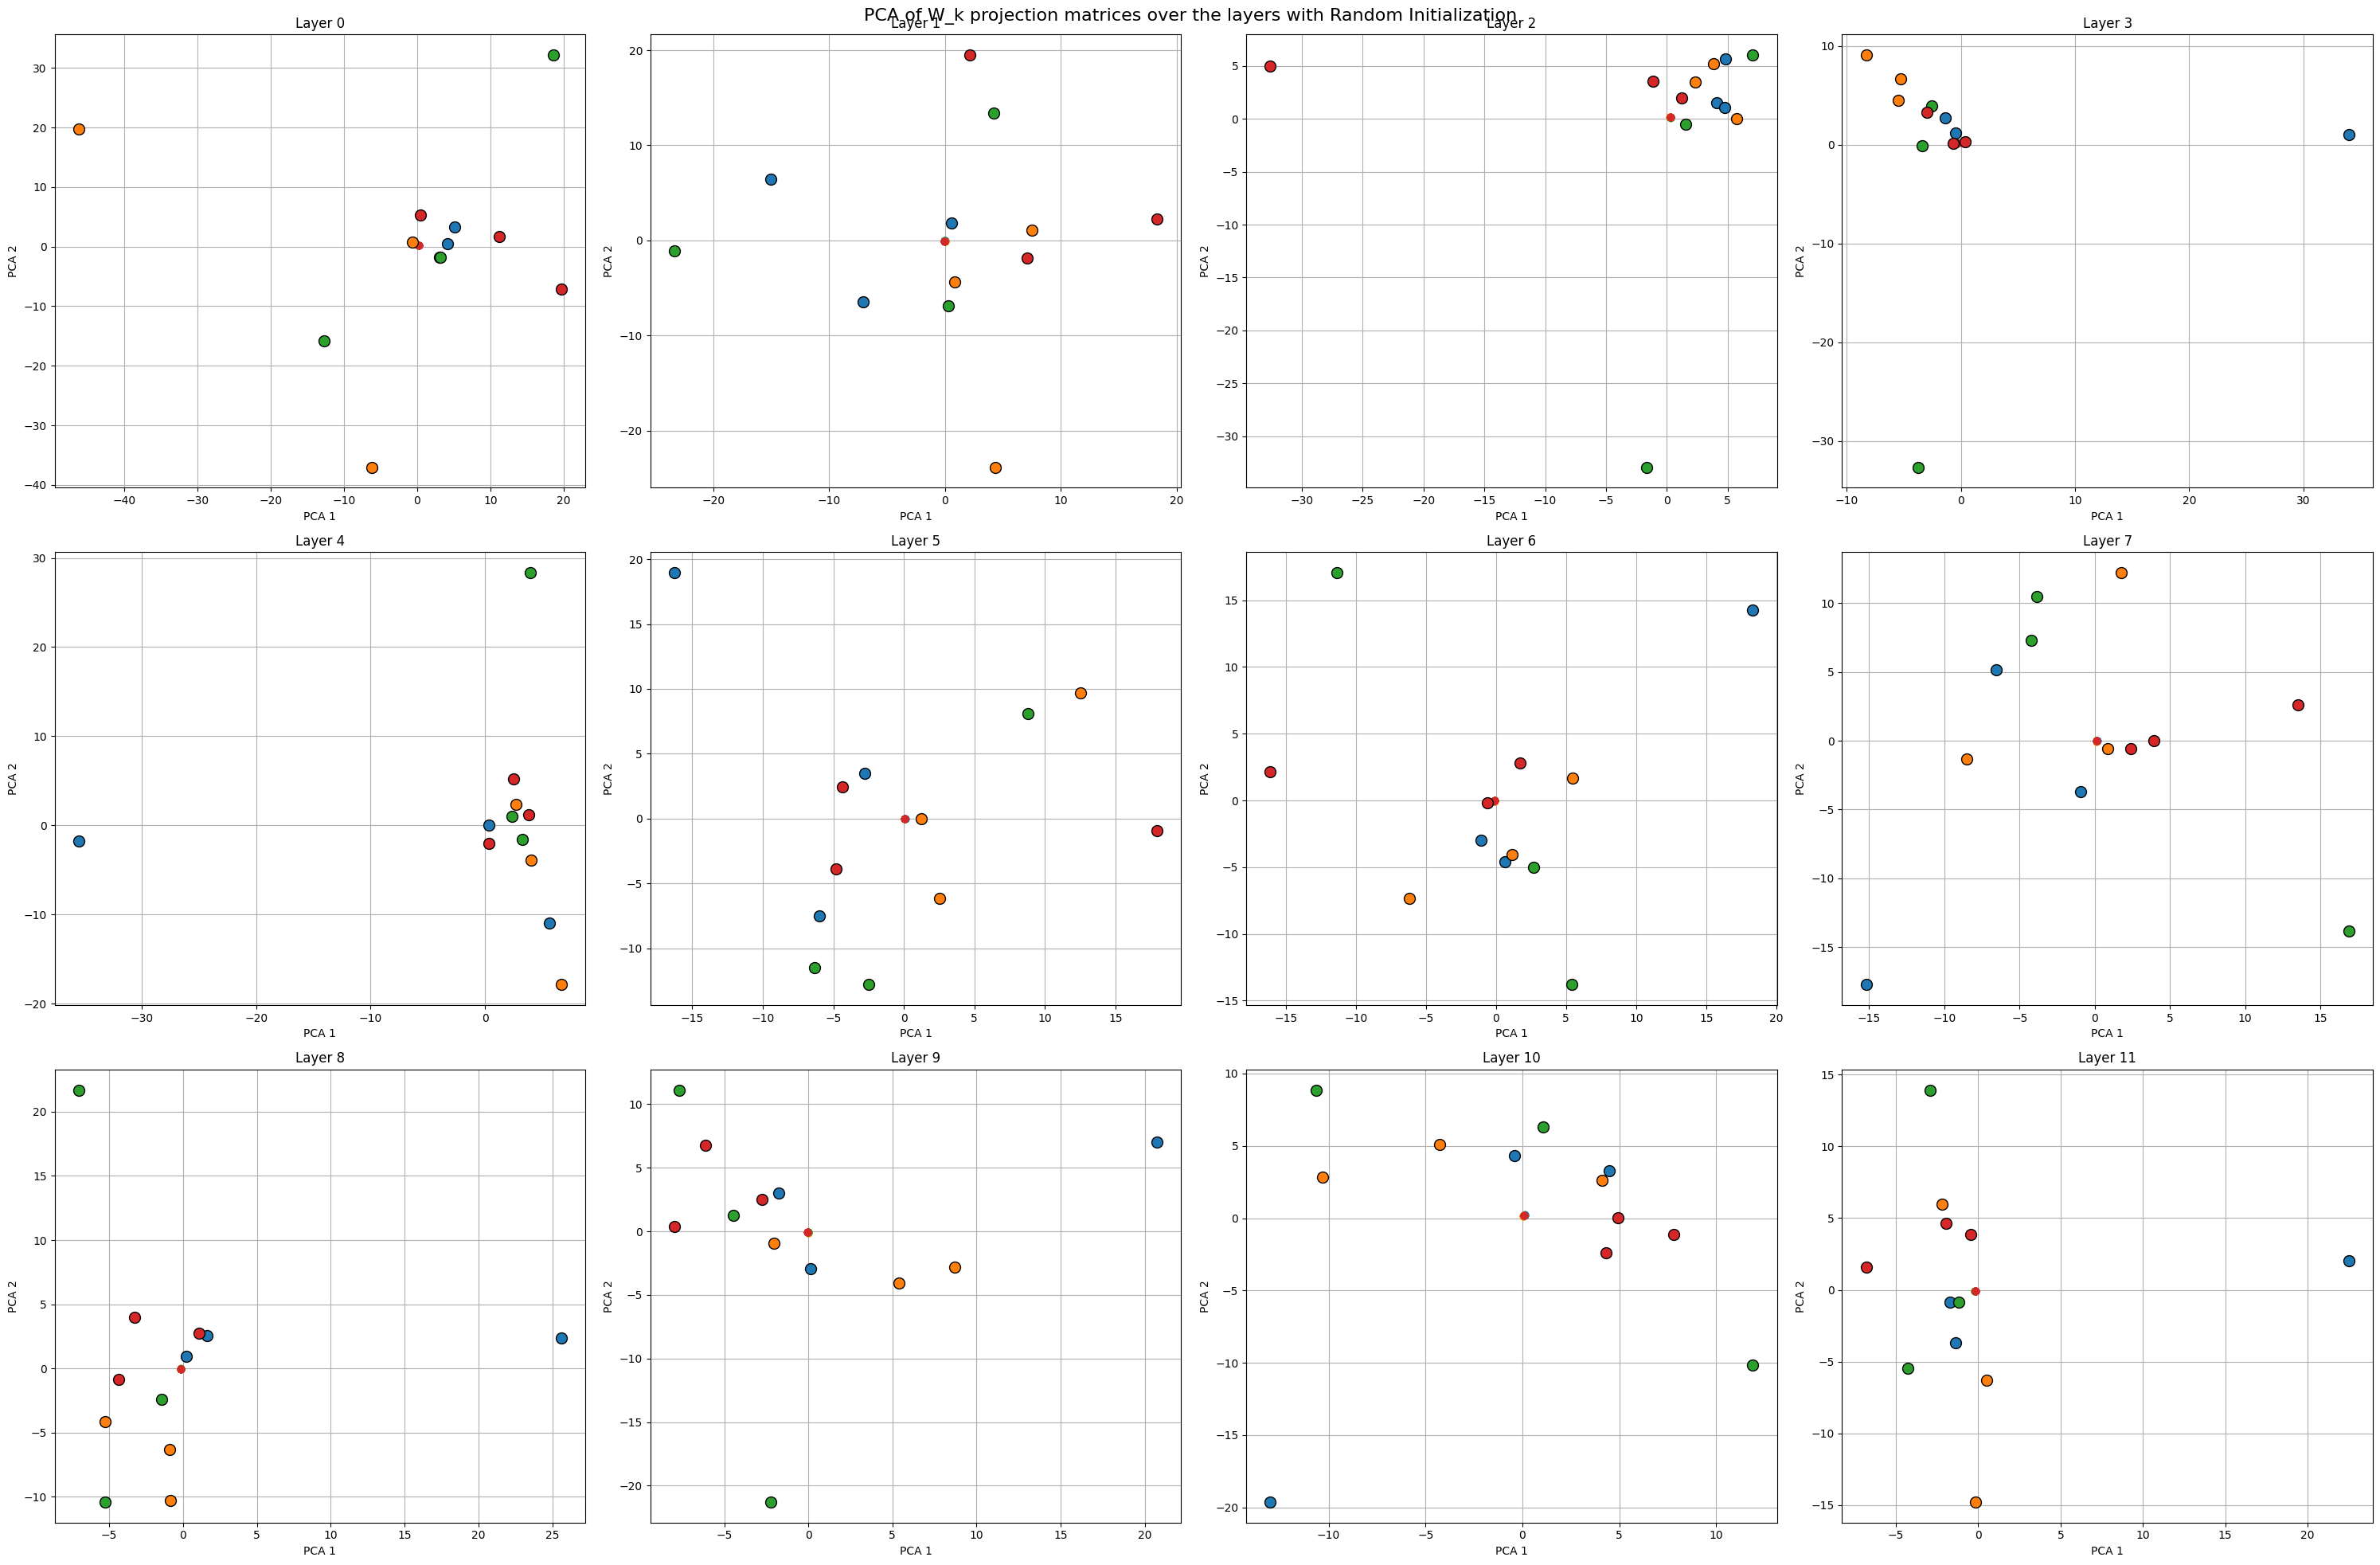

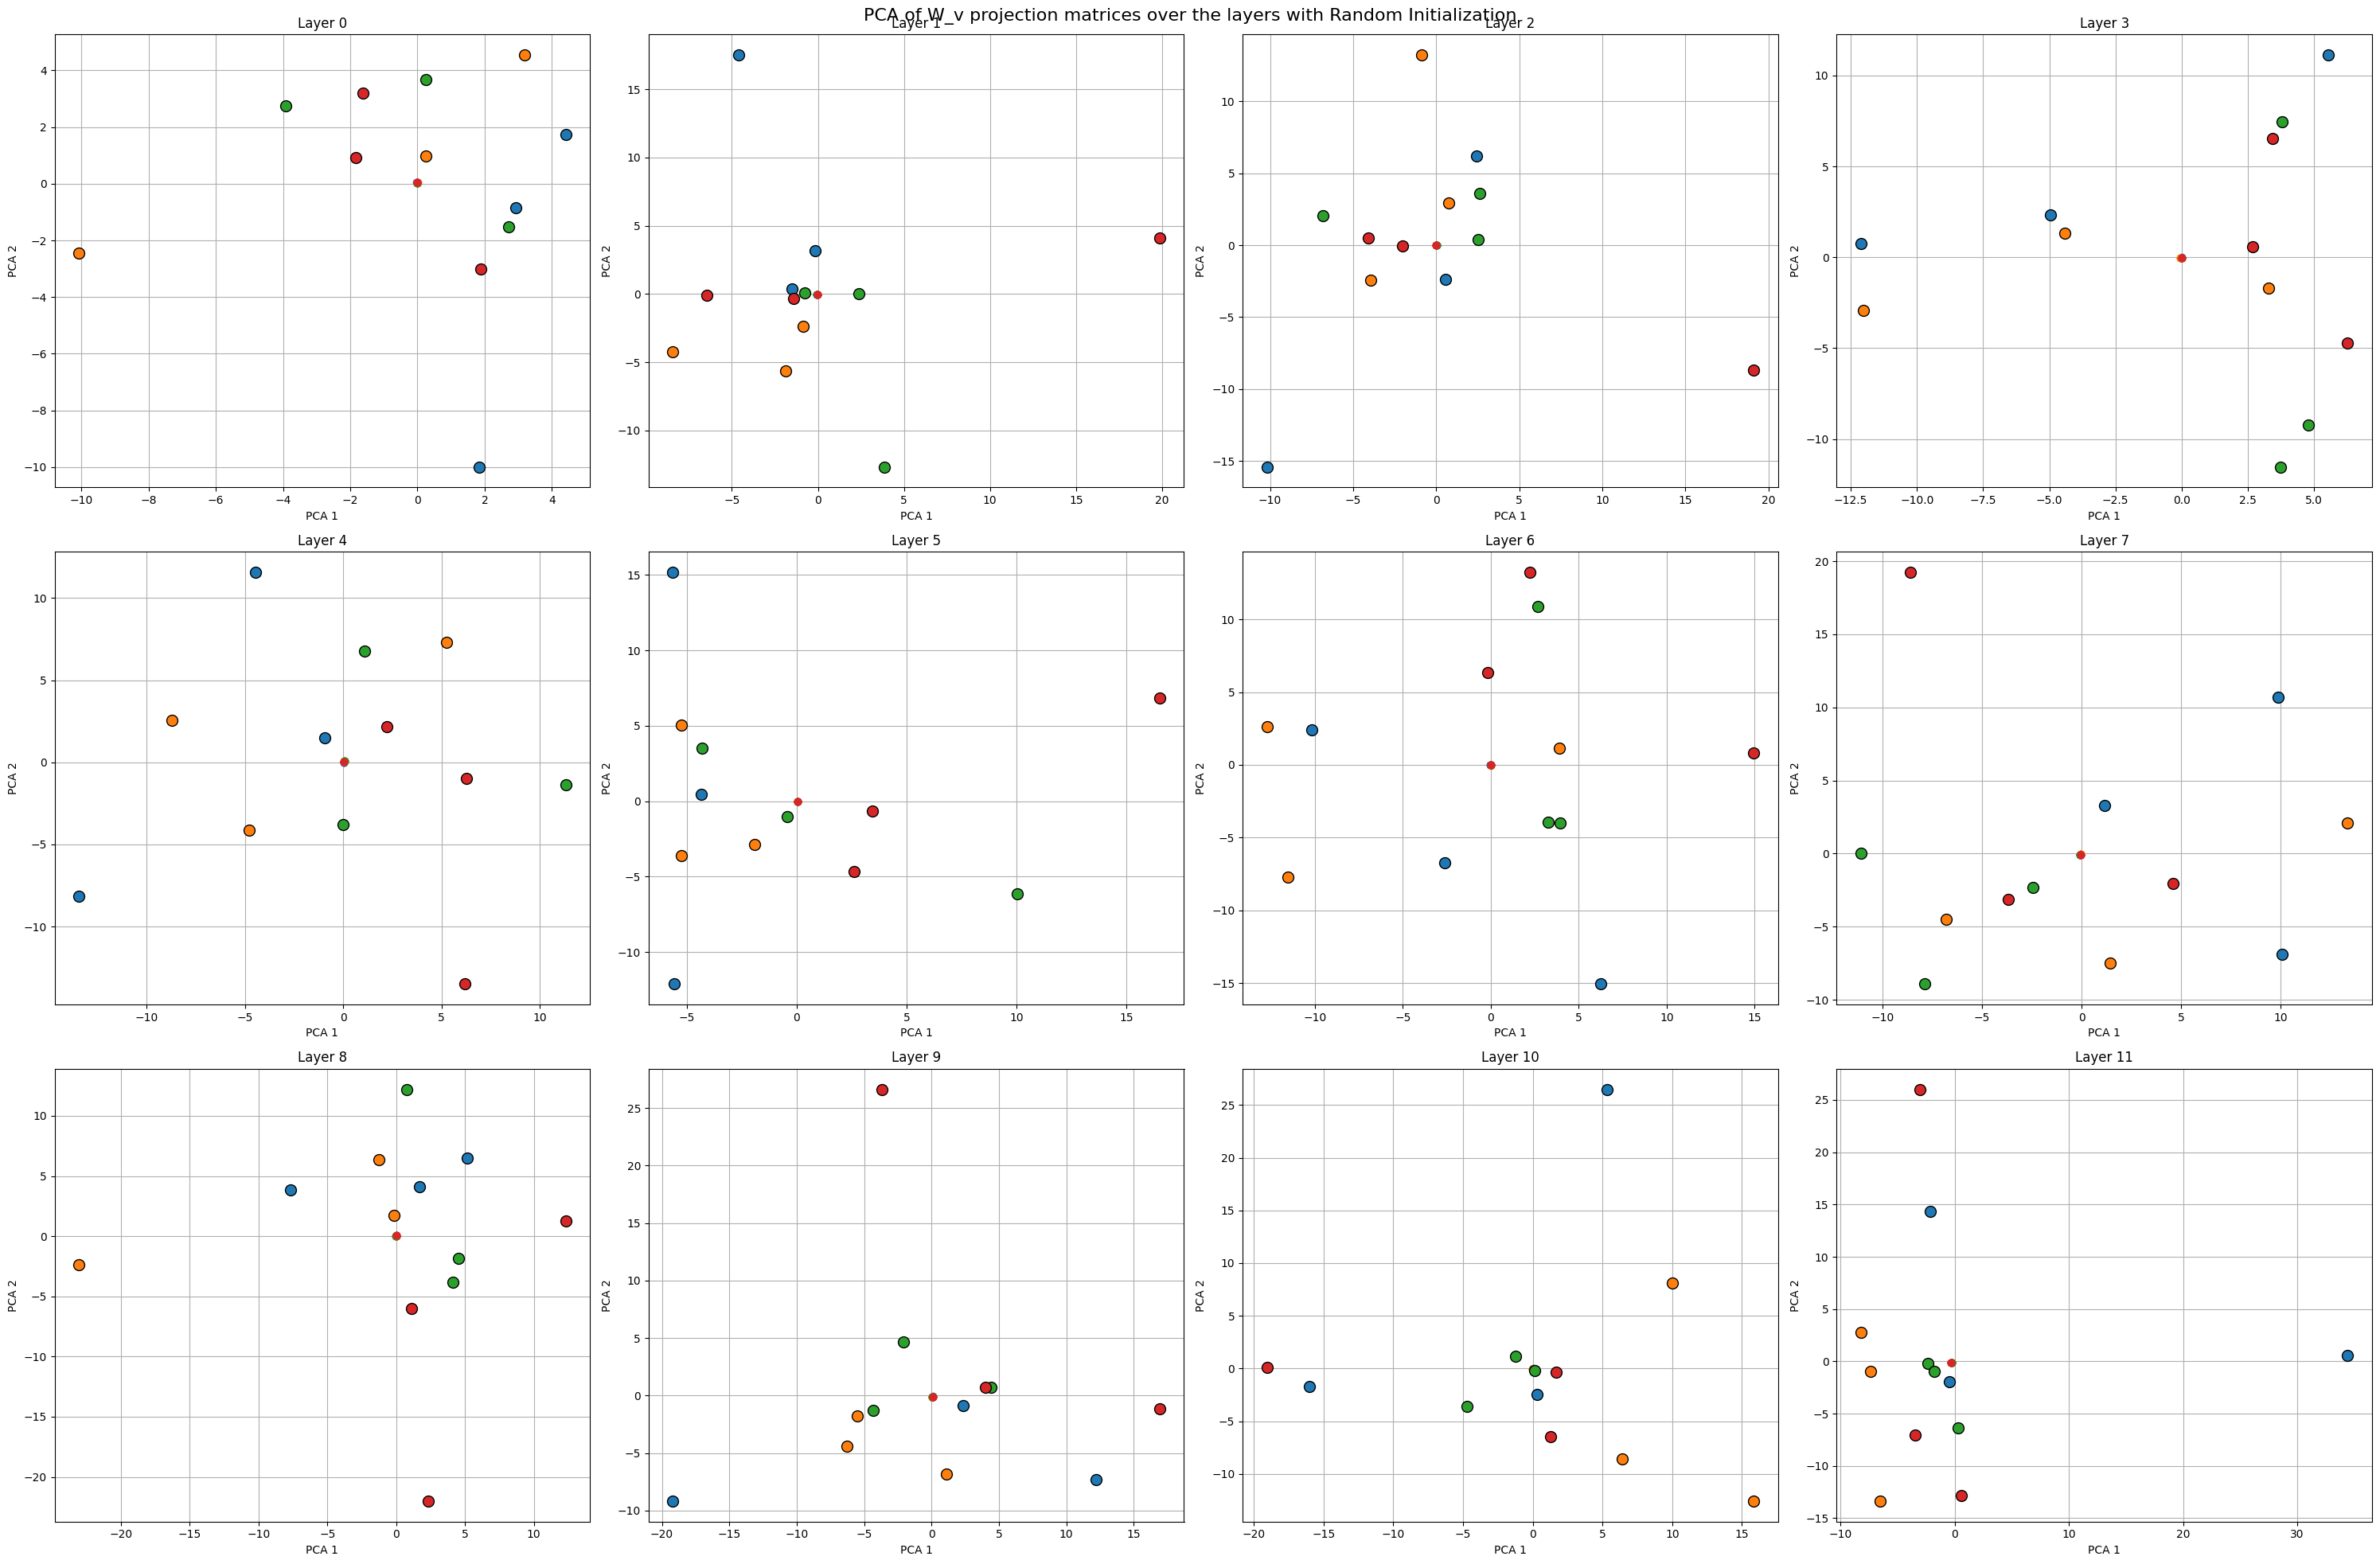

In [17]:

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.cm as cm

pca = PCA(n_components=2)

for name in ["W_q", "W_k", "W_v"]:
  fig, axes = plt.subplots(3, 4, figsize=(30, 20))
  fig.suptitle(f'PCA of {name} projection matrices over the layers with Random Initialization', fontsize=16)
  for i in range(len(model.transformer.h)):
    row = i // 4
    col = i % 4
    ax = axes[row, col]
    ax.set_title(f'Layer {i}')

    num_heads = 4

    if name == 'W_q':
      num_heads = 12

    trajectories = []
    for trajectory in list(matrix_evolution[i][name]):
      temp = list(trajectory)
      trajectories.append([t.flatten() for t in temp])

    flattened_traj = [m for traj in trajectories for m in traj]

    T = len(list(matrix_evolution[i][name][0]))
    origin = list(original_matrices[i][name].view(12,49152))

    reduced = pca.fit_transform(origin)
    reduced_orig = reduced[:12]

    # Plot each trajectory
    for j in range(num_heads):

        traj = pca.transform(trajectories[j]).reshape(T,2)
        # Draw the trajectory line
        ax.plot(traj[:, 0], traj[:, 1], marker='o', linewidth=2, label=f'Head {j}')

    # Plot original positions with labels
    labels = ['Group 1', 'Group 2', 'Group 3', 'Group 4']

    for group_idx in range(len(labels)):
        group_points = reduced_orig[group_idx * 3 : (group_idx + 1) * 3]
        x, y = group_points[:, 0], group_points[:, 1]
        ax.scatter(x, y, edgecolor='black', s=100, zorder=5, label=labels[group_idx])

    # ax.legend()
    ax.grid(True)
    ax.set_xlabel("PCA 1")
    ax.set_ylabel("PCA 2")
  plt.tight_layout()
  plt.show()
